In [1]:
!pip install nltk


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: c:\users\harshita\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip


In [2]:
import os
import torch
import time
import json
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
# import pandas as pd
import re
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Harshita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Harshita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
folder_path = r"C:\Users\Harshita\Downloads\case study\Transcripts"
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path) & filename.endswith(".csv"):
        print(f"\nProcessing file: {filename}")
        input_data = pd.read_csv(file_path, sep=None, engine='python')
        print(f"\nFile Loaded!")     


Processing file: adg0001_er_2024_10_31.csv

File Loaded!


In [4]:
transcript_text = " ".join(input_data["Transkript"].dropna().astype(str))

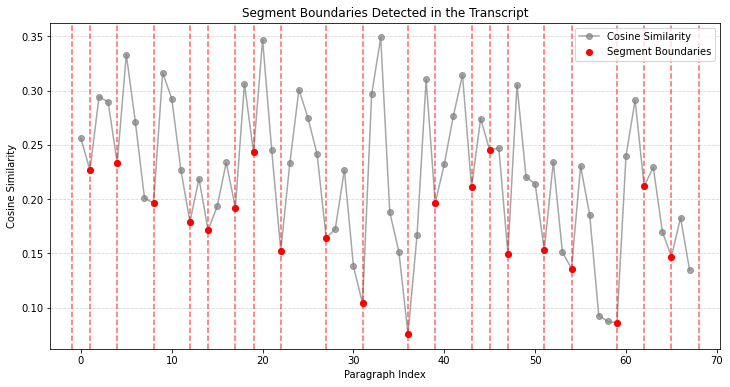

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def split_into_paragraphs(text, sentences_per_paragraph=10):
    """
    Splits the text into paragraphs containing a fixed number of sentences.
    """
    sentences = sent_tokenize(text)
    paragraphs = []
    for i in range(0, len(sentences), sentences_per_paragraph):
        paragraphs.append(" ".join(sentences[i:i+sentences_per_paragraph]))
    return paragraphs

def segment_text_by_local_minima(text, sentences_per_paragraph=10):
    """
    Segments a transcript into chunks by detecting local minima in cosine similarity
    between adjacent paragraphs. Returns a DataFrame with one column 'Segment'
    containing each segment's text.
    """
    # Split text into paragraphs
    paragraphs = split_into_paragraphs(text, sentences_per_paragraph)
    
    if len(paragraphs) <= 1:
        return pd.DataFrame({"Segment": [text]})
    
    # Vectorize paragraphs using TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(paragraphs)
    
    # Compute cosine similarity between consecutive paragraphs
    similarities = [cosine_similarity(tfidf_matrix[i], tfidf_matrix[i+1])[0][0] for i in range(len(paragraphs) - 1)]
    
    # Identify local minima: where the similarity is less than its immediate neighbors
    boundaries = [0]  # Starting index of first segment
    for i in range(1, len(similarities) - 1):
        if similarities[i] < similarities[i-1] and similarities[i] < similarities[i+1]:
            boundaries.append(i + 1)
    boundaries.append(len(paragraphs))


    # Visualization of cosine similarity and segmentation points
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(similarities)), similarities, linestyle='-', marker='o', color='grey', alpha=0.7, label="Cosine Similarity")
    plt.scatter([b-1 for b in boundaries if b != 0 and b != len(paragraphs)], [similarities[b-1] for b in boundaries if b != 0 and b != len(paragraphs)], 
                color='red', zorder=3, label="Segment Boundaries")
    
    for idx in boundaries:
        plt.axvline(x=idx-1, color='red', linestyle='dashed', alpha=0.6)

    plt.xlabel("Paragraph Index")
    plt.ylabel("Cosine Similarity")
    plt.title("Segment Boundaries Detected in the Transcript")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    
    # Build segments from boundaries
    segments = [" ".join(paragraphs[boundaries[i]:boundaries[i+1]]) for i in range(len(boundaries) - 1)]
    
    return pd.DataFrame({"Segment": segments})


df_segments = segment_text_by_local_minima(transcript_text)


The graph visualizes how we detect segment boundaries.The grey line represents the cosine similarity scores between consecutive paragraphs, capturing the natural flow of the conversation. Lower similarity values indicate potential shifts in topic. The red dots mark detected segment boundaries, corresponding to local minima where a significant change in context is identified. The vertical dashed red lines further emphasize these breakpoints, visually segmenting the transcript into coherent chunks. This method ensures that each segment retains contextual integrity while preventing abrupt topic fragmentation, ultimately enhancing the accuracy of metadata extraction.